# Load data

In [1]:
import json
import torch
from torch import nn
from torch.optim import Adam
from transformers import AutoModel, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load the dataset
with open("clinc150_uci/data_full.json", "r") as file:
    data = json.load(file)


In [2]:
# Extracting data
train_data = data['train']
val_data = data['val']
test_data = data['test']

oos_train_data = data['oos_train']
oos_val_data = data['oos_val']
oos_test_data = data['oos_test']

# Get sentences and labels
train_sentences = [item[0] for item in train_data]
train_labels = [item[1] for item in train_data]

val_sentences = [item[0] for item in val_data]
val_labels = [item[1] for item in val_data]

test_sentences = [item[0] for item in test_data]
test_labels = [item[1] for item in test_data]

oos_train_sentences = [item[0] for item in oos_train_data]
oos_val_sentences = [item[0] for item in oos_val_data]
oos_test_sentences = [item[0] for item in oos_test_data]

# Check the number of samples in each subset
len(train_sentences), len(val_sentences), len(test_sentences), len(oos_train_sentences), len(oos_val_sentences), len(oos_test_sentences)


(15000, 3000, 4500, 100, 100, 1000)

In [3]:
unique_intents = list(set(train_labels)) 
unique_intents[:5]

['schedule_maintenance', 'calendar', 'reminder_update', 'sync_device', 'yes']

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, transformer_model, num_labels):
        super(TextClassifier, self).__init__()
        self.transformer = transformer_model
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        # Get the output from the transformer model
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        # Pool the outputs into a single sentence vector
        # You can use `transformer_output.last_hidden_state.mean(dim=1)` for mean pooling
        # or `transformer_output.last_hidden_state.max(dim=1).values` for max pooling
        sentence_embedding = transformer_output.last_hidden_state.max(dim=1).values
        # Forward pass through the classifier layer
        return self.classifier(sentence_embedding)

In [12]:
train_embeddings = encode_sentences(train_sentences)
val_embeddings = encode_sentences(val_sentences)
test_embeddings = encode_sentences(test_sentences)
oos_train_embeddings = encode_sentences(oos_train_sentences)
oos_val_embeddings = encode_sentences(oos_val_sentences)
oos_test_embeddings = encode_sentences(oos_test_sentences)

In [15]:
val_embeddings.shape

(3000, 768)

In [36]:
import numpy as np
from scipy.linalg import inv

In [39]:
intent_means = {}
for intent in unique_intents:
    indices = [i for i, label in enumerate(train_labels) if label == intent]
    intent_embeddings = train_embeddings[indices]
    intent_mean = np.mean(intent_embeddings, axis=0)
    intent_means[intent] = intent_mean

In [40]:
len(intent_means)

150

In [41]:
intent_means["damaged_card"].shape

(768,)

In [42]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

In [43]:
covariance = np.cov(train_embeddings, rowvar=False)
cov_inverse = inv(covariance)

In [44]:
from scipy.spatial import distance

In [45]:
# Function to get the minimum Mahalanobis distance to any intent for a given sample
def min_mahalanobis_for_sample(sample, intent_means, cov_inverse):
    distances = [distance.mahalanobis(sample, mean, cov_inverse) for mean in intent_means.values()]
    return min(distances)


In [46]:
from sklearn.metrics import average_precision_score

# Compute minimum Mahalanobis distances for samples in test_embeddings and oos_test_embeddings
test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in test_embeddings]
oos_test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in oos_test_embeddings]

# True binary labels: 0 for in-domain and 1 for OOD
y_true = [0] * len(test_scores) + [1] * len(oos_test_scores)

# Combine the scores
y_scores = test_scores + oos_test_scores

# Compute AUPR
aupr = average_precision_score(y_true, y_scores)
aupr


0.9187354216276238

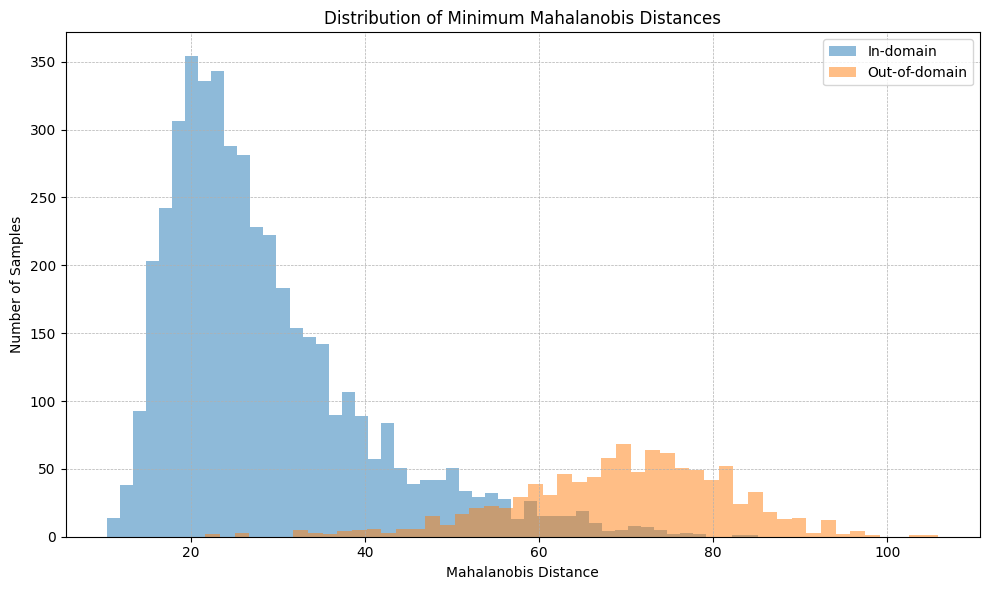

In [47]:
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(test_scores, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_test_scores, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Minimum Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


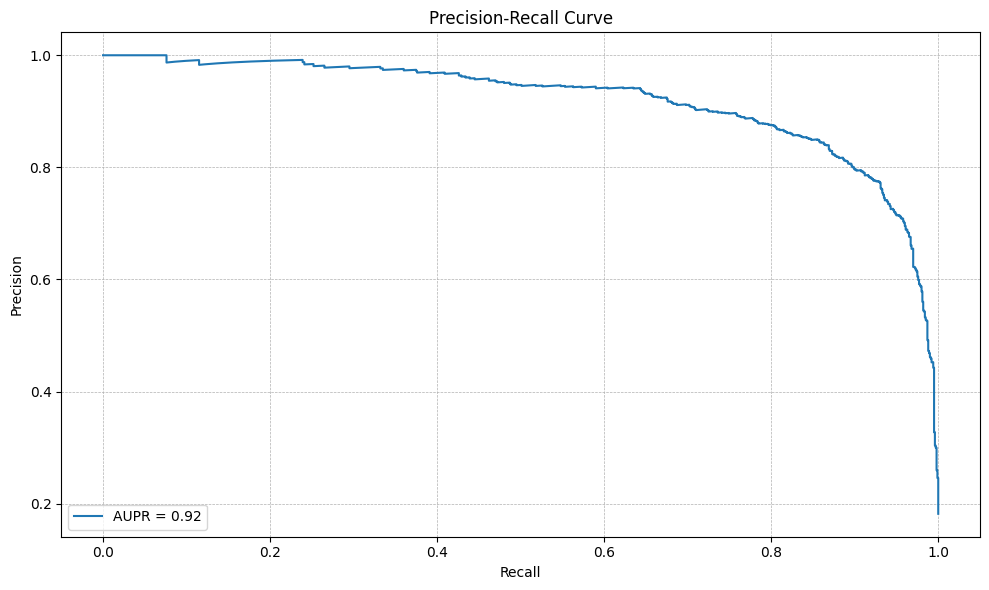

In [48]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Calculate the area under the precision-recall curve
aupr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AUPR = {aupr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [49]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Find the FPR where the TPR is closest to 0.95
idx = np.where(tpr >= 0.95)[0][0]
fpr_95 = fpr[idx]

fpr_95

0.08355555555555555

# KNN, K=1

In [50]:
from sklearn.neighbors import NearestNeighbors

# Initialize and fit the Nearest Neighbors model (with k=1)
knn = NearestNeighbors(n_neighbors=1)
knn.fit(train_embeddings)

NearestNeighbors(n_neighbors=1)

In [51]:
train_embeddings.shape

(15000, 768)

In [52]:
# Compute the distances to the nearest neighbors for the in-domain test set
distances_in, _ = knn.kneighbors(test_embeddings)
# Compute the distances to the nearest neighbors for the OOD test set
distances_out, _ = knn.kneighbors(oos_test_embeddings)

In [53]:
scores_in = distances_in.squeeze()
scores_out = distances_out.squeeze()

In [54]:
y_scores_knn = np.concatenate([scores_in, scores_out])

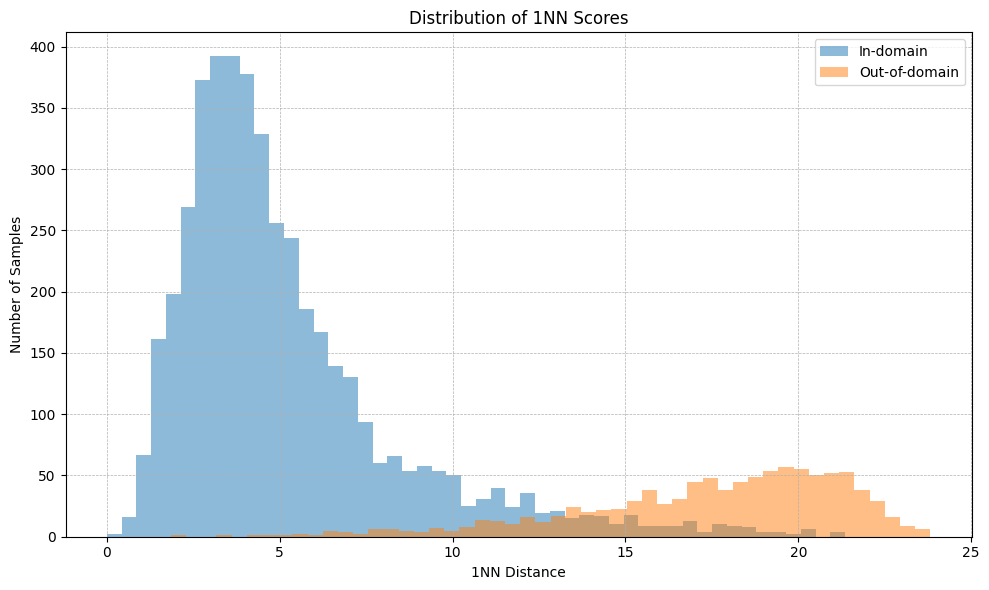

In [55]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(distances_in, bins=50, alpha=0.5, label='In-domain')
plt.hist(distances_out, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of 1NN Scores')
plt.xlabel('1NN Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [56]:
y_true_knn = [0] * len(scores_in) + [1] * len(scores_out)

In [57]:
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_true_knn, y_scores_knn)

In [58]:
aupr_knn = average_precision_score(y_true_knn, y_scores_knn)
aupr_knn


0.9105105645463031

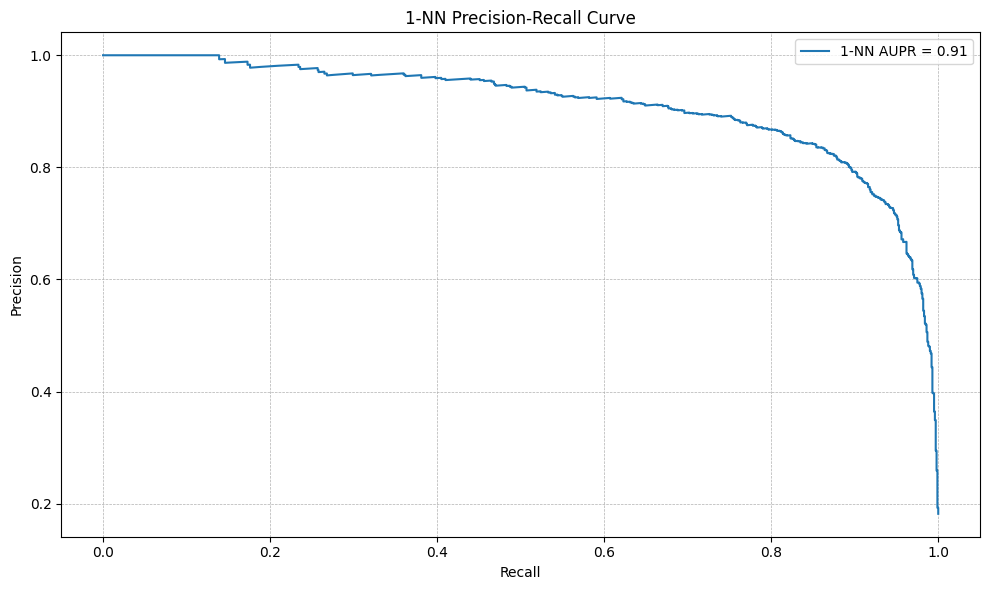

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(recall_knn, precision_knn, label=f'1-NN AUPR = {aupr_knn:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('1-NN Precision-Recall Curve')
plt.legend(loc='upper right') # Changed to 'upper right' to avoid overlap with the curve.
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [60]:
fpr, tpr, thresholds = roc_curve(y_true_knn, y_scores_knn)

# Find the FPR where the TPR is closest to 0.95
idx = np.where(tpr >= 0.95)[0][0]
fpr_95 = fpr[idx]

fpr_95

0.084

# K-MEANS

In [62]:
from sklearn.cluster import KMeans

In [63]:
kmeans = KMeans(n_clusters=150, random_state=42).fit(train_embeddings)

/home/ztybigcat/Desktop/my_own_ood/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [64]:
test_distances_to_center = np.min(kmeans.transform(test_embeddings), axis=1)
oos_test_distances_to_center = np.min(kmeans.transform(oos_test_embeddings), axis=1)


In [65]:
y_scores_kmeans = np.concatenate([test_distances_to_center, oos_test_distances_to_center])

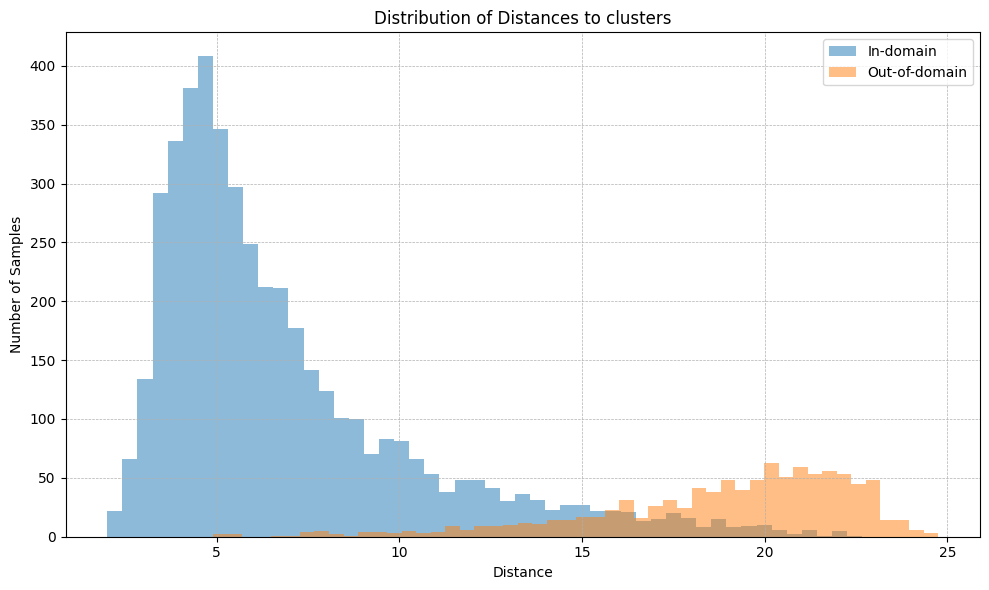

In [66]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(test_distances_to_center, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_test_distances_to_center, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Distances to clusters')
plt.xlabel('Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [67]:
precision_kmeans, recall_kmeans, thresholds_kmeans = precision_recall_curve(y_true, y_scores_kmeans)

In [68]:
precision_kmeans, recall_kmeans

(array([0.18181818, 0.18185125, 0.18188432, ..., 1.        , 1.        ,
        1.        ]),
 array([1.   , 1.   , 1.   , ..., 0.002, 0.001, 0.   ]))

In [69]:
aupr_knn = average_precision_score(y_true, y_scores_kmeans)
aupr_knn

0.8985912702336968

# Fine tunning based on intents

In [303]:
train_sentences[:10]

['what expression would i use to say i love you if i were an italian',
 "can you tell me how to say 'i do not speak much spanish', in spanish",
 "what is the equivalent of, 'life is good' in french",
 "tell me how to say, 'it is a beautiful morning' in italian",
 'if i were mongolian, how would i say that i am a tourist',
 "how do i say 'hotel' in finnish",
 "i need you to translate the sentence, 'we will be there soon' into portuguese",
 'please tell me how to ask for a taxi in french',
 "can you tell me how i would say, 'more bread please' in french",
 "what is the correct way to say 'i am a visitor' in french"]

In [304]:
train_labels[:10]

['translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate']

In [75]:
label_encoder = LabelEncoder()

# Fit the label encoder and transform labels to integers
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.fit_transform(val_labels)

In [76]:
val_sentences[:3]

['in spanish, meet me tomorrow is said how',
 'in french, how do i say, see you later',
 'how do you say hello in japanese']

In [77]:
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer

# Your train_sentences and encoded_train_labels
# train_sentences = ["sentence 1", "sentence 2", ...]
# encoded_train_labels = [0, 1, ...]

# 1. Tokenize the sentences
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

class TextDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(sentences, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 2. Create the dataset
max_length = 37 
train_dataset = TextDataset(train_sentences, encoded_train_labels, tokenizer, max_length)
val_dataset = TextDataset(val_sentences, encoded_val_labels, tokenizer, max_length)

# 3. Create the data loader
batch_size=128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [102]:
# Define a new class for the classification model
class TextClassifier(nn.Module):
    def __init__(self, transformer_model, num_labels):
        super(TextClassifier, self).__init__()
        self.transformer = transformer_model
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        # Get the output from the transformer model
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        # Pool the outputs into a single sentence vector
        # You can use `transformer_output.last_hidden_state.mean(dim=1)` for mean pooling
        # or `transformer_output.last_hidden_state.max(dim=1).values` for max pooling
        sentence_embedding = transformer_output.last_hidden_state.max(dim=1).values
        # Forward pass through the classifier layer
        return self.classifier(sentence_embedding)

In [79]:
num_epochs = 12

In [99]:
num_labels = 150  # Number of labels for your classification task

pretrained_model_name = "distilroberta-base"  # or any other model you wish to use


In [101]:
while validation_losses[-1] > 0.15:
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
    transformer_model = AutoModel.from_pretrained(pretrained_model_name)
    # Create an instance of the classification model
    model = TextClassifier(transformer_model, num_labels)
    
    # Move model to the device (GPU/CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Define loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=2.2497695787641236e-05)
    training_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        # Training Phase
        model.train()  # Set the model to training mode
        total_train_loss = 0
        for batch in train_dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
    
            optimizer.zero_grad()  # Zero the gradients
            predictions = model(input_ids, attention_mask)  # Forward pass
            loss = loss_function(predictions, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
    
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        training_losses.append(avg_train_loss) 
    
        # Validation Phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():  # Disable gradient calculations
            for batch in val_dataloader:
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                predictions = model(input_ids, attention_mask)  # Forward pass
                loss = loss_function(predictions, labels)  # Compute loss
                total_val_loss += loss.item()
    
        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

Epoch 1/12, Training Loss: 4.143435156951516, Validation Loss: 2.30752727886041
Epoch 2/12, Training Loss: 1.5768644400572374, Validation Loss: 0.7714178214470545
Epoch 3/12, Training Loss: 0.6176868616524389, Validation Loss: 0.4055916927754879
Epoch 4/12, Training Loss: 0.3263507981674146, Validation Loss: 0.2894592331722379
Epoch 5/12, Training Loss: 0.20196547548649674, Validation Loss: 0.23501309162626663
Epoch 6/12, Training Loss: 0.1371540031948332, Validation Loss: 0.2154220654629171
Epoch 7/12, Training Loss: 0.09835546694190825, Validation Loss: 0.18811084873353442
Epoch 8/12, Training Loss: 0.07309404858466932, Validation Loss: 0.18288794656594595
Epoch 9/12, Training Loss: 0.05645198223449416, Validation Loss: 0.16549274791032076
Epoch 10/12, Training Loss: 0.044362782548039645, Validation Loss: 0.16766001656651497
Epoch 11/12, Training Loss: 0.03573698714628058, Validation Loss: 0.17100620968267322
Epoch 12/12, Training Loss: 0.029116692021489143, Validation Loss: 0.172291

KeyboardInterrupt: 

In [29]:
min_i = 0
min_val = 99999
for i, val in enumerate(validation_losses):
    if val < min_val:
        min_val = val
        min_i = i
min_i
                

11

In [9]:
# After training, save the model and the classifier
fine_tuned_transformer_model = model.transformer
model_path = 'sentence_transformer_model'
# Save the fine-tuned transformer model
fine_tuned_transformer_model.save_pretrained(model_path)
tokenizer_path = 'tokenizer'
tokenizer.save_pretrained(tokenizer_path)

NameError: name 'model' is not defined

In [10]:
# Load and prepare the model and tokenizer
model_path = 'sentence_transformer_model'
tokenizer_path = 'tokenizer'

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModel.from_pretrained(model_path)
model.eval()  # Put the model in evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
def encode_sentences(sentences):
    sentence_embeddings = []

    for sentence in sentences:
        encoded_input = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}  # Move input to GPU if available

        with torch.no_grad():
            model_output = model(**encoded_input)

        pooled_output = model_output.last_hidden_state.mean(dim=1)
        sentence_embeddings.append(pooled_output.cpu().numpy())

    sentence_embeddings_np = np.concatenate(sentence_embeddings, axis=0)
    return sentence_embeddings_np


In [ ]:
import optuna
from transformers import AutoTokenizer, AutoModel

# Assuming other necessary imports are already there

def objective(trial):
    # Optuna suggests hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 5e-5, log=True)
    num_epochs = trial.suggest_int('num_epochs', 5, 50)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])

    training_losses = []
    validation_losses = []
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    # Model setup
    num_labels = 150
    pretrained_model_name = "distilroberta-base"
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
    transformer_model = AutoModel.from_pretrained(pretrained_model_name)
    model = TextClassifier(transformer_model, num_labels)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # Training Phase
        model.train()  # Set the model to training mode
        total_train_loss = 0
        for batch in train_dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
    
            optimizer.zero_grad()  # Zero the gradients
            predictions = model(input_ids, attention_mask)  # Forward pass
            loss = loss_function(predictions, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
    
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        training_losses.append(avg_train_loss)    
        # Validation Phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():  # Disable gradient calculations
            for batch in val_dataloader:
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                predictions = model(input_ids, attention_mask)  # Forward pass
                loss = loss_function(predictions, labels)  # Compute loss
                total_val_loss += loss.item()
    
        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_losses.append(avg_val_loss)
    trial.set_user_attr("training_losses", training_losses)
    trial.set_user_attr("validation_losses", validation_losses)
    return avg_val_loss

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize',  study_name='ood_detection_study_big', storage='sqlite:///result-big.db')
study.optimize(objective, n_trials=1000)  # n_trials is the number of iterations

# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)


[I 2023-11-15 21:24:13,407] A new study created in RDB with name: ood_detection_study_big
[I 2023-11-15 21:26:04,294] Trial 0 finished with value: 0.1668306358327019 and parameters: {'lr': 1.2873241971363653e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 0 with value: 0.1668306358327019.
[I 2023-11-15 21:29:35,311] Trial 1 finished with value: 0.18366344831883907 and parameters: {'lr': 1.0190028020390266e-05, 'num_epochs': 43, 'batch_size': 256}. Best is trial 0 with value: 0.1668306358327019.
[I 2023-11-15 21:31:49,780] Trial 2 finished with value: 0.1686201288442438 and parameters: {'lr': 1.852842866648285e-05, 'num_epochs': 25, 'batch_size': 128}. Best is trial 0 with value: 0.1668306358327019.
[I 2023-11-15 21:34:29,181] Trial 3 finished with value: 0.2178720369293513 and parameters: {'lr': 4.453848940294404e-05, 'num_epochs': 12, 'batch_size': 32}. Best is trial 0 with value: 0.1668306358327019.
[I 2023-11-15 21:35:55,855] Trial 4 finished with value: 0.1654229088065525 an